In [1]:
!pip install pandas_ta
!pip install neat-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=be658427ef5d773936b4e16925b550df4eced43271270ff8dbf42203628c640f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import random
import neat
import string

In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


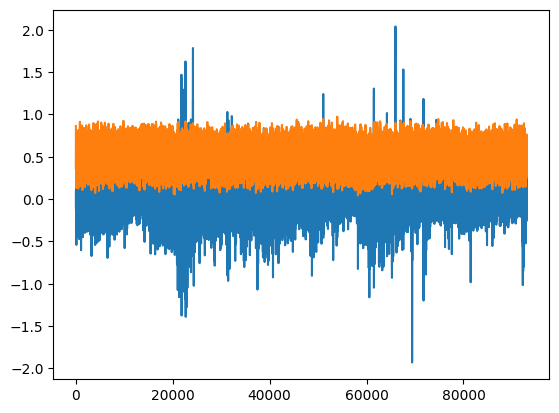

In [7]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = ((cur_move*trade_direction)-.1)
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value += cur_move*trade_direction if trade_direction != 0 else 0
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)
          print(cash_out_value)

    return np.sum(returns) if len(returns)>1 else 0

In [12]:
def run_env_loop(net,rand,debug):
    profit = 0
    bought = False
    sold = False
    trade_counter = 0
    for count in range(rand, rand+1000):
        outputs = net.activate(INDICATORS[count])
        action = 0 if outputs[0]>outputs[1] else 1

        if action == 0:
          profit += change[count+1]
          trade_counter += 1
          bought = True
        elif action == 1:
          sold = True
          profit += change[count+1]*-1
        else:
          profit += 0

        if debug:
          print([action,profit])


    trade_ratio = trade_counter/1000
    trade_ratio = abs(trade_ratio-.5)*1.5
    penelty = trade_ratio*abs(profit)

    if bought and sold:
      fitness = profit + -penelty
    else:
      fitness = -100

    return fitness

In [13]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 70000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [14]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [25]:
winner = p.run(eval_genomes,10)


 ****** Running generation 1166 ****** 

Population's average fitness: -46.08548 stdev: 46.42159
Best fitness: 45.24904 - size: (8, 5) - species 118 - id 165531
Average adjusted fitness: 0.439
Mean genetic distance 2.696, standard deviation 0.701
Population of 150 members in 8 species
Total extinctions: 0
Generation time: 0.577 sec (0.625 average)

 ****** Running generation 1167 ****** 

Population's average fitness: -18.52293 stdev: 49.91198
Best fitness: 65.97370 - size: (12, 6) - species 121 - id 165577
Average adjusted fitness: 0.452
Mean genetic distance 2.669, standard deviation 0.667
Population of 151 members in 8 species
Total extinctions: 0
Generation time: 0.532 sec (0.550 average)

 ****** Running generation 1168 ****** 

Population's average fitness: -39.48187 stdev: 43.23953
Best fitness: 10.61605 - size: (8, 6) - species 118 - id 165779
Average adjusted fitness: 0.515
Mean genetic distance 2.682, standard deviation 0.652
Population of 150 members in 8 species
Total exti

In [26]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [27]:
run_env_loop(net,70000,True)

[0, 0.7988013867545268]
[0, 1.7002730762560678]
[0, 1.7888450663531414]
[0, 1.9290689068926865]
[0, 4.600245369299845]
[0, 5.534328498365164]
[0, 6.768560305047326]
[0, 6.0129957242940675]
[0, 5.1098875666252725]
[0, 5.697922514861065]
[0, 6.645449491980862]
[0, 6.667459574075164]
[0, 6.726151551196527]
[0, 7.012254464984753]
[0, 6.190912109388469]
[0, 5.8679184280390615]
[0, 6.462754697406326]
[0, 6.235266306108512]
[0, 6.15452222207165]
[0, 6.712445367985053]
[0, 6.763798091710235]
[0, 6.162275278238293]
[0, 5.677767409459565]
[0, 6.000963589243359]
[0, 5.318113487321811]
[0, 6.493888323069022]
[0, 5.657348050506193]
[0, 5.077048408391861]
[1, 4.452233276360346]
[0, 4.621172194761513]
[0, 4.804763635924315]
[0, 5.193890382881924]
[0, 4.893010562964545]
[0, 4.672773799482735]
[0, 4.812294549655519]
[0, 4.643429737220812]
[0, 4.452499767307018]
[0, 4.415773915480592]
[0, 4.599411397971753]
[0, 4.621442962738683]
[0, 5.00331316035724]
[0, 4.438114689409649]
[0, 4.878832805538651]
[0, 4.

6.3129767686679985

In [28]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [32]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [29]:
print(winner)

Key: 166757
Fitness: 24.190517498832087
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.04376727363556108, response=1.0, activation=relu, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.9587239853311452, response=1.0, activation=relu, aggregation=sum)
	31556 DefaultNodeGene(key=31556, bias=3.092466911999782, response=1.0, activation=relu, aggregation=sum)
	32015 DefaultNodeGene(key=32015, bias=0.48870270939420735, response=1.0, activation=relu, aggregation=sum)
	32926 DefaultNodeGene(key=32926, bias=0.6680702018079232, response=1.0, activation=relu, aggregation=sum)
	33359 DefaultNodeGene(key=33359, bias=0.31534459583190316, response=1.0, activation=relu, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-2, 0), weight=0.9247219902905285, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=5.4735027419238715, enabled=True)
	DefaultConnectionGene(key=(-1, 31556), weight=-1.3582254016141806, enabled=False)
	DefaultConnectionGene(key=(32926, 31556), weight=-0.9541752036196955, ena

In [33]:
for item in node_list:
       print(item)

F = relu(0.31534459583190316)
E = relu(0.6680702018079232)
D = relu(0.48870270939420735)
C = relu(F * -0.6065226891439224 + 3.092466911999782)
B = relu(0.9587239853311452)
A = relu(P1 * 5.4735027419238715 + P2 * 0.9247219902905285 + -0.04376727363556108)
